# Prevendo o Fluxo de Clientes 

# Introdução

Um dos deafios de qualquer negócio é prever situações futuras que possam causar problemas. Podemos citar duas situações opostas, dias em o estabelecimento está lotado e dias com pouco movimento. No primeiro caso, precisaríamos contratar mais funcionários temporários e ealizar mais compras para manter o estoque e produtos bem abastecido, já na outra situação, essas ações não seriam necessárias. Saber o fluxo de clientes está diretamente ligado a previsão de gastos do estabelecimento.

## Objetivo 

Usar os modelos estaísticos ARIMA e SARIMA, juntamente com os dados dos anos anteriores, para prever o fluxo de clientes em um estabelecimento.

# Dataset

O dataset utilizado contém dados do número de clientes em um estabelecimento comercial entre o anos de 2012 a 2018.

Link: <a href="https://www.kaggle.com/shaclo/retail" target="_blanck"> Kaggle - Customer flow between 2012-2018</a>

## Importando as Bibliotecas 

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from scipy import stats
from scipy.stats import normaltest

from sklearn.metrics import mean_squared_error
import datetime

color = sns.color_palette()
sns.set_style('darkgrid')
import warnings 
warnings.filterwarnings('ignore')


In [31]:
# importando os dados
flow = pd.read_csv("passflow-w.csv")
flow

,weekday,txdate,passflow
0,5,2018-09-07,18379
1,4,2018-09-06,14666
2,3,2018-09-05,14015
3,2,2018-09-04,13929
4,1,2018-09-03,14437
...,...,...,...
2436,5,2012-01-06,18203
2437,4,2012-01-05,11621
2438,3,2012-01-04,11344
2439,2,2012-01-03,20116


In [32]:
# arrumando o formato das datas
flow['date'] = pd.to_datetime(flow['txdate'],format="%Y-%m-%d")
# apaga as colunas antigas
flow = flow.drop(['weekday','txdate'],axis=1)
# ordena a tabela em ordem cronológica
flow = flow.sort_values(by='date', ascending=True)


In [33]:
print(f'O dataset tem {flow.shape[0]} linhas e {flow.shape[1]} colunas')

O dataset tem 2441 linhas e 2 colunas


## Processando os Dados

In [34]:
# cópia dos dados
train = flow.copy()

Vamos quebrar oa datas em dias e meses

In [37]:
# separa os anos
train['year'] = train['date'].dt.year
# separa os meses
train['month'] = train['date'].dt.month
# separa os dias
train['day'] = train['date'].dt.dayofyear
# separa os dias da semana
train['weekday'] = train['date'].dt.weekday

dic = {0:'Segunda', 1:'Terça', 2:'Quarta', 3:'Quinta', 4:'Sexta', 5:'Sábado', 6:'Domingo'}
train['weekday'] = train['weekday'].map(dic)

dic2 = {1:"Jan", 2:"Fev", 3:"Mar", 4:"Abr", 5:"Mai", 6:"Jun",
        7:"Jul", 8:"Ago", 9:"Set", 10:"Out", 11:"Nov", 12:"Dez"}
train['month'] = train['month'].map(dic2)


## Decompondo e Analisando a Série Temporal

Primeiro vamos olhar os dados originais, como foi o fluxo de clientes nos anos

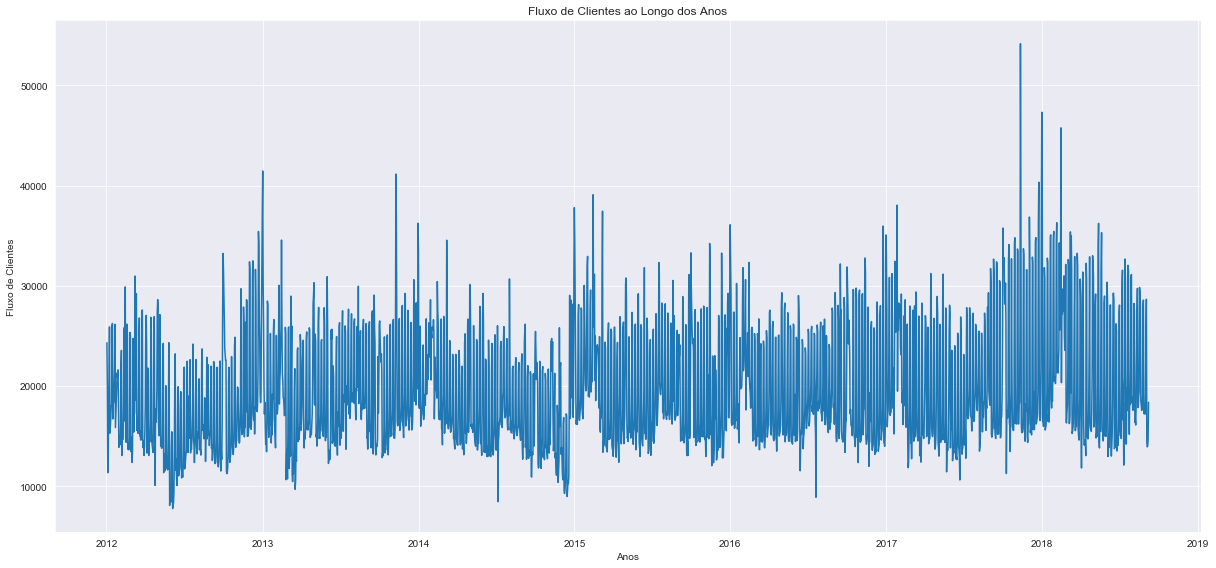

In [38]:
plt.figure(figsize=(17,8))
sns.lineplot(x='date', y="passflow", data=train)
plt.title("Fluxo de Clientes ao Longo dos Anos")
plt.xlabel("Anos")
plt.ylabel("Fluxo de Clientes")
plt.tight_layout()
plt.show()

O gráfico acima possui muitos dados, o que torna difícil a sua visulização. Vamos pegar somente os primeiros 100 dias e colocar em um gráfico.

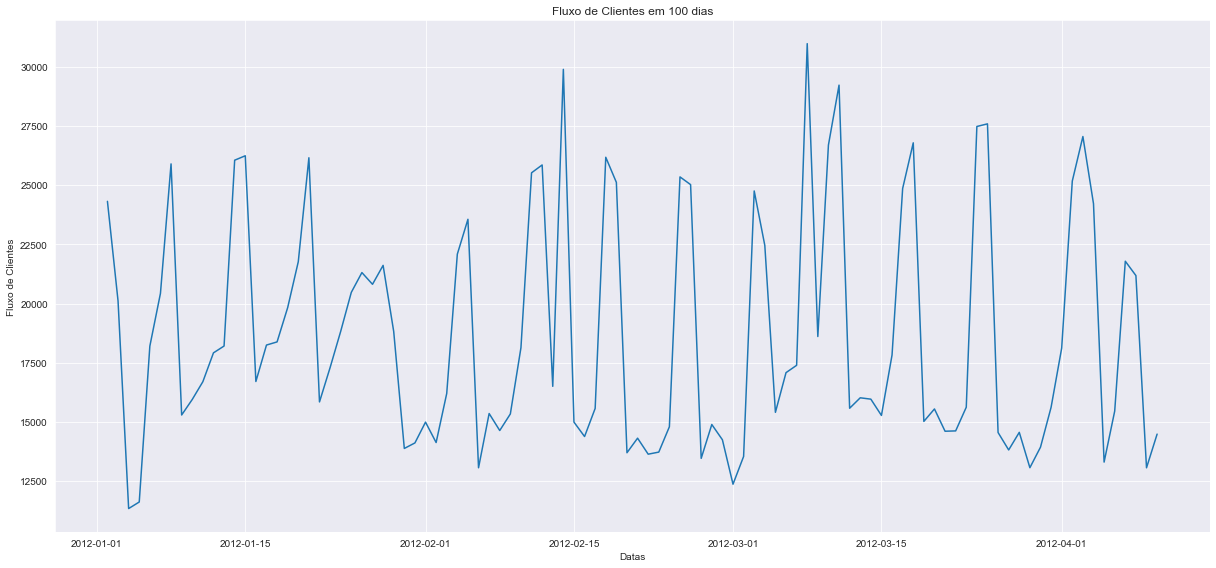

In [39]:
plt.figure(figsize=(17,8))
sns.lineplot(x='date', y="passflow", data=train[:100])
plt.title("Fluxo de Clientes em 100 dias")
plt.xlabel("Datas")
plt.ylabel("Fluxo de Clientes")
plt.tight_layout()
plt.show()

Mesmo com essa mudança, continua difícil tirar qualquer conclusão do gráfico. Vamos tentar outra abordagem, olhar o fluxo nos dias da semana.

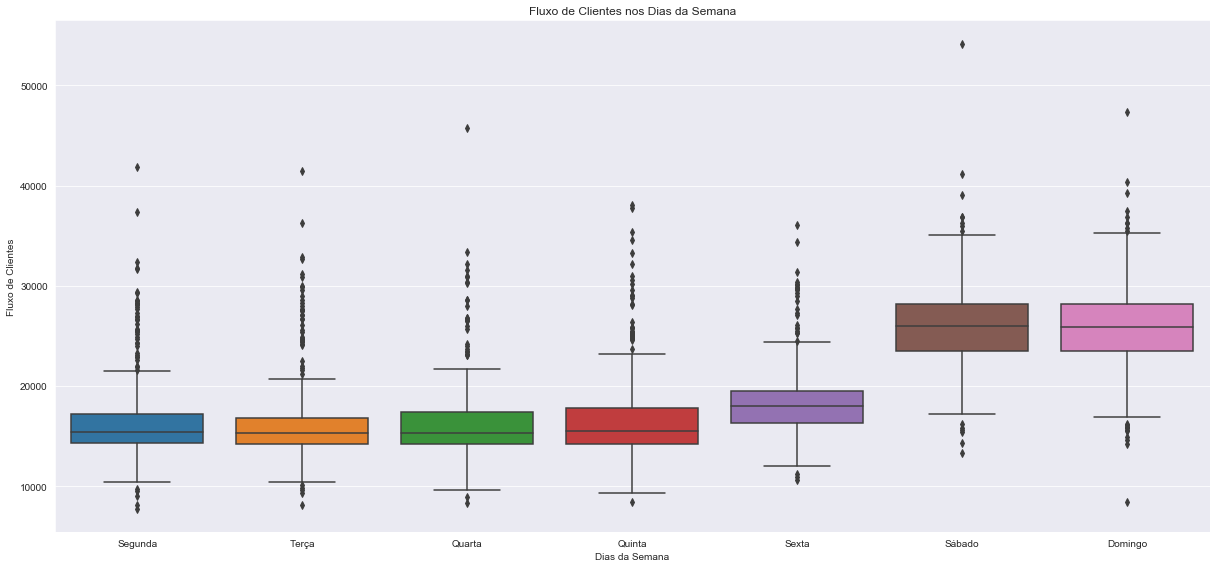

In [40]:
ordem = ("Segunda", "Terça","Quarta","Quinta","Sexta","Sábado","Domingo")
plt.figure(figsize=(17,8))
sns.boxplot(x='weekday', y="passflow", data=train, order=ordem)
plt.title("Fluxo de Clientes nos Dias da Semana")
plt.xlabel("Dias da Semana")
plt.ylabel("Fluxo de Clientes")
plt.tight_layout()
plt.show()

Insigth:

* Do gráfico acima vemos que no fim de semana (sábado e domingo) tivemos um fluxo maior de clientes, já dias de semana o fluxo foi menor.

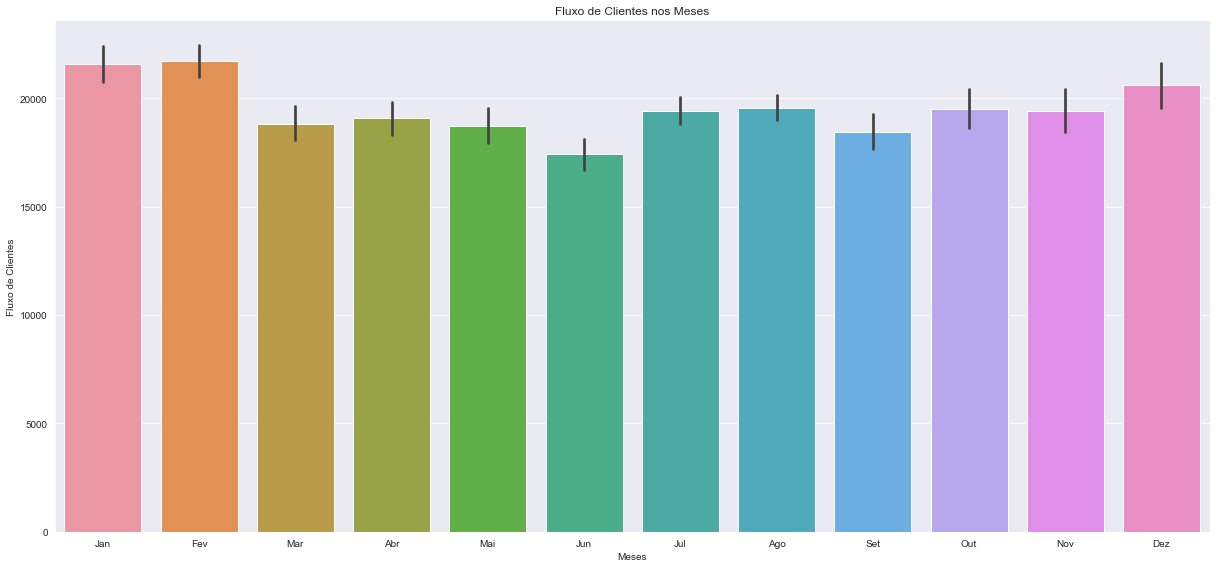

In [41]:

plt.figure(figsize=(17,8))
sns.barplot(x='month', y='passflow', data=train)
plt.title("Fluxo de Clientes nos Meses")
plt.xlabel("Meses")
plt.ylabel("Fluxo de Clientes")
plt.tight_layout()
plt.show()

Insigth:

* Do gráfico acima vemos que nos meses de janeiro, fevereiro e dezembro tivemos um fluxo maior de clientes, já junho e setembro tiveram o menor fluxo.

Vamos criar outro dataframe agora colocando as datas como índices da tabela.

In [42]:
train_df = train.set_index('date')
train_df['passflow'] = train_df['passflow'].astype(float)

In [43]:
train_df

,passflow,year,month,day,weekday
date,,,,,
2012-01-02,24317.0,2012,Jan,2,Segunda
2012-01-03,20116.0,2012,Jan,3,Terça
2012-01-04,11344.0,2012,Jan,4,Quarta
2012-01-05,11621.0,2012,Jan,5,Quinta
2012-01-06,18203.0,2012,Jan,6,Sexta
...,...,...,...,...,...
2018-09-03,14437.0,2018,Set,246,Segunda
2018-09-04,13929.0,2018,Set,247,Terça
2018-09-05,14015.0,2018,Set,248,Quarta


Queremos decompor os dados para separar a sazonalidade, tendência e residual. Já que temos 6 anos de dados de fluxo de clientes, esperamos que haja um padrão anual ou semanal. Vamos usar uma função em modelos de estatísticas para nos ajudar a encontrá-lo. 

<Figure size 432x288 with 0 Axes>

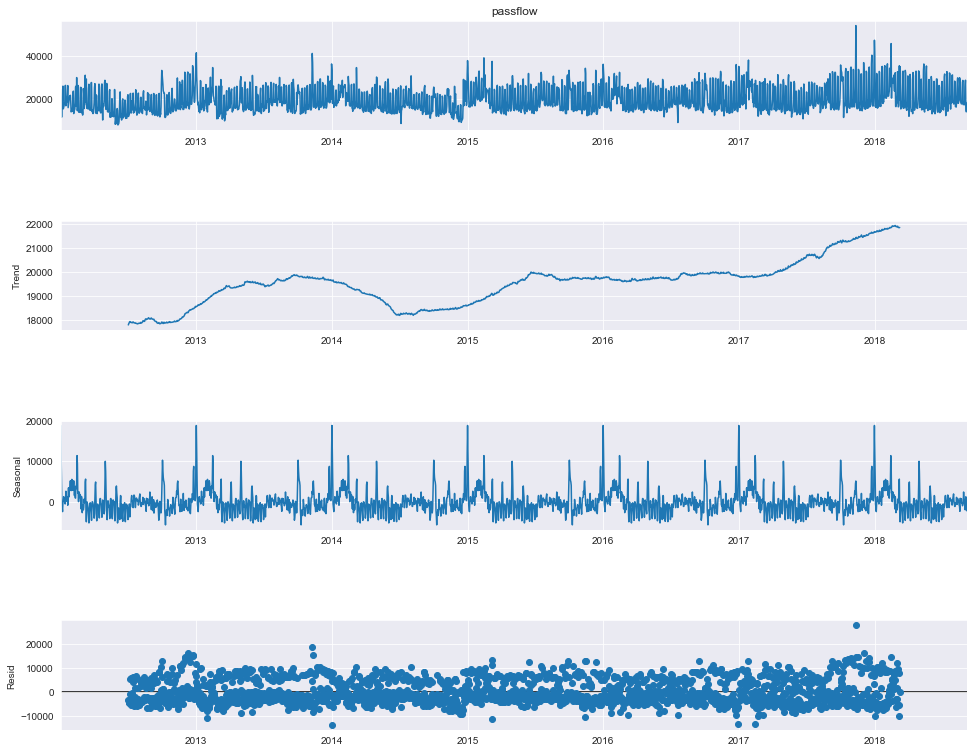

In [44]:
result = seasonal_decompose(train_df['passflow'], model='additive',freq=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

Insigths:

* Temos uma tendência ascendente em 2013, uma tendência decrescente até metade de 2014, uma retomada co crescimento no fim de 2015 e durante 2015, uma estagnação durante 2016.

* Temos um discreto padrão anual. 

## Dados Estacionários

Os dados são estacionários quando a média, o desvio padrão e a corelação entre o i-ésimo termo e o (i+m)-ésimo termos não são funções do tempo.

Por que isso é importante? Ao executar uma regressão linear, a suposição é que todas as observações são independentes umas das outras. Em uma série temporal, entretanto, sabemos que as observações dependem do tempo. Acontece que muitos bons resultados válidos para variáveis ​​aleatórias independentes (lei dos grandes números e teorema do limite central, para citar alguns) são válidos para variáveis ​​aleatórias estacionárias. Portanto, ao tornar os dados estacionários, podemos aplicar técnicas de regressão a essa variável dependente do tempo.

Existem duas maneiras de verificar a estacionariedade de uma série temporal. A primeira é ver os dados. Ao visualizar os dados, deve ser fácil identificar uma mudança na média ou variação no desvio padrão dados. Para uma avaliação mais precisa, existe o teste Dickey-Fuller. Se a ‘Estatística do Teste’ for maior que o ‘Valor Crítico’, a série temporal é estacionária.

In [45]:
# Função que avalia se a série temporal é estacionária
def test_stationarity(timeseries, window =12, cutoff= 0.05):

    # determina a rolagem estatística
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    # gráficos da rolagem estatística média e desvio padrão
    fig = plt.figure(figsize=(18,8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Média Móvel')
    std = plt.plot(rolstd, color='black', label = 'Std Móvel')
    plt.legend(loc='best')
    plt.title('Média e Desvio Padrão Móvel')
    plt.show()

    # performando teste Dickey-Fuller
    print('Resultadosdo Teste de Dickey-Fuller:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag=20)
    dfoutput = pd.Series(dftest[0:4], index=['Teste Estatístico','p-value','#Lags Usados','Número de Observações Usadas'])
    for key, value in dftest[4].items():
        dfoutput['Valor Crítico (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. A séries é provavelmente ESTACIONÁRIA.' % pvalue)
    else:
        print('p-value = %.4f. A séries é provavelmente NÃO ESTACIONÁRIA.' % pvalue)
    
    print(dfoutput)


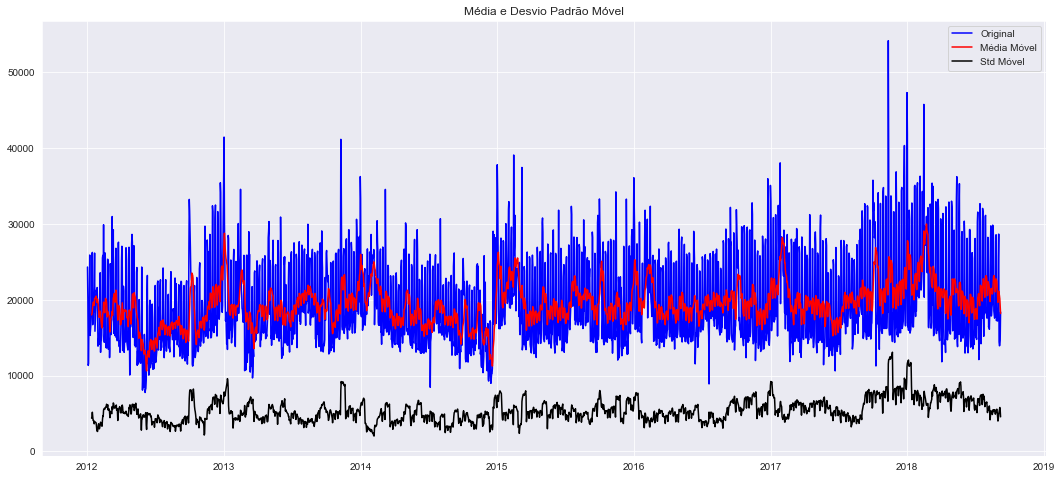

Resultadosdo Teste de Dickey-Fuller:
p-value = 0.0000. A séries é provavelmente ESTACIONÁRIA.
Teste Estatístico              -5.761308e+00
p-value                         5.663915e-07
#Lags Usados                    2.000000e+01
Número de Observações Usadas    2.420000e+03
Valor Crítico (1%)             -3.433055e+00
Valor Crítico (5%)             -2.862735e+00
Valor Crítico (10%)            -2.567406e+00
dtype: float64


In [46]:
test_stationarity(train_df['passflow'])

* O valor quase nulo e 'p-value' (muito menor que qualquer um dos valors críticos) já é por si só uma boa indicação de que a série é estcionária.

* O valor do Teste Estatístico -5.582530 é muito menor que qualquer valor crítico, o que reforma o fato da série temporal ser estacionária.

Para ter ainda mais certeza, poemos fazer a diferença entre o i-éssimo dado e o (i+1)-ésimo


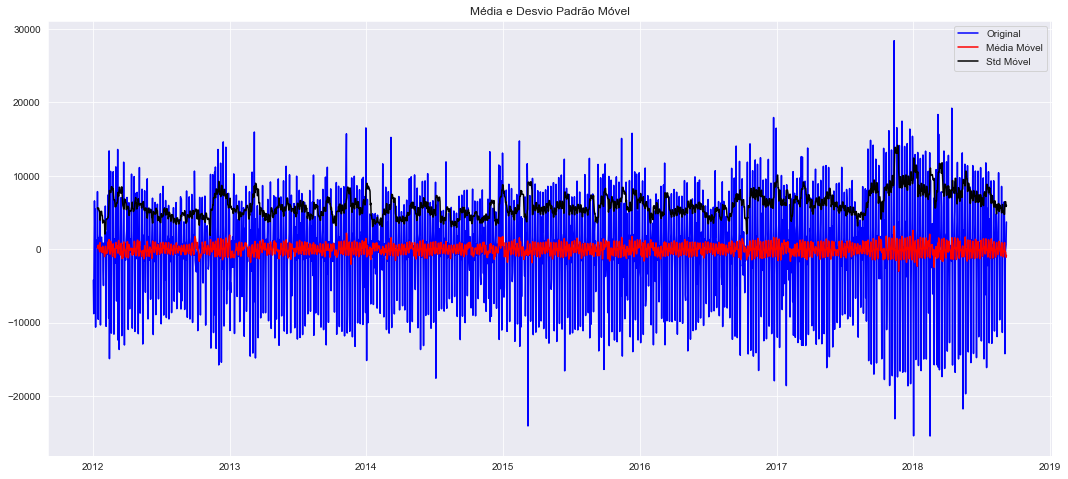

Resultadosdo Teste de Dickey-Fuller:
p-value = 0.0000. A séries é provavelmente ESTACIONÁRIA.
Teste Estatístico              -1.659684e+01
p-value                         1.778789e-29
#Lags Usados                    2.000000e+01
Número de Observações Usadas    2.419000e+03
Valor Crítico (1%)             -3.433056e+00
Valor Crítico (5%)             -2.862736e+00
Valor Crítico (10%)            -2.567406e+00
dtype: float64


In [47]:
first_diff = train_df.passflow - train_df.passflow.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

De fato, nossa série temporal é estacionária.

## ACF and PACF
Uma vez que temos séries estacionárias, podemos adimitir que a distribuição das variáveis se ajustam em uma distribuição Gaussiana. Podemos então calcular a correlação para observações de séries temporais com observações com intervalos de tempo anteriores, chamados de atrasos ("lags").

A função de autocorrelação(ACF), descreve a autocorrelação entre uma observação e outra observação em uma etapa de tempo anterior que inclui informações de dependência direta e indireta. A função de autocorrelação parcial (PACF), descreve apenas a relação direta entre uma observação e seu atraso. 

Os intervalos de confiança são desenhados como um cone. Por padrão, é definido um intervalo de confiança de 95%, sugerindo que os valores de correlação fora desse limite são muito provavelmente uma correlação e não uma flutuação estatística. 

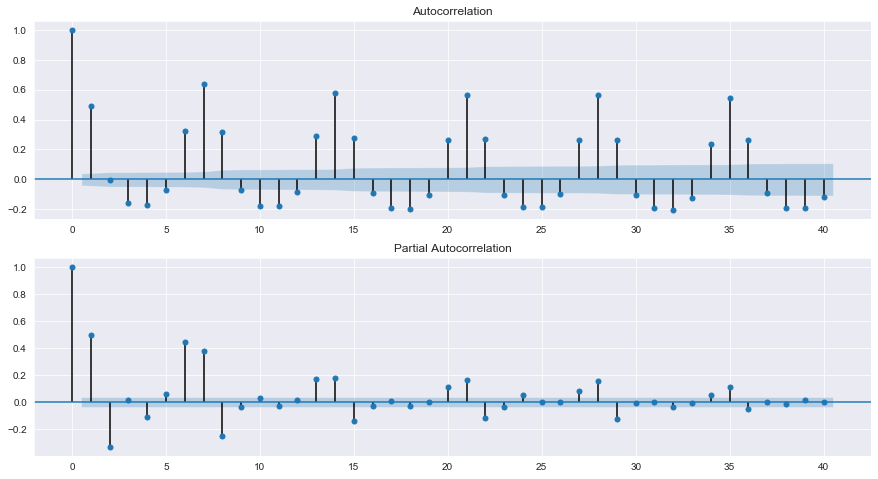

In [48]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df.passflow, lags=40, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df.passflow, lags=40, ax=ax2)

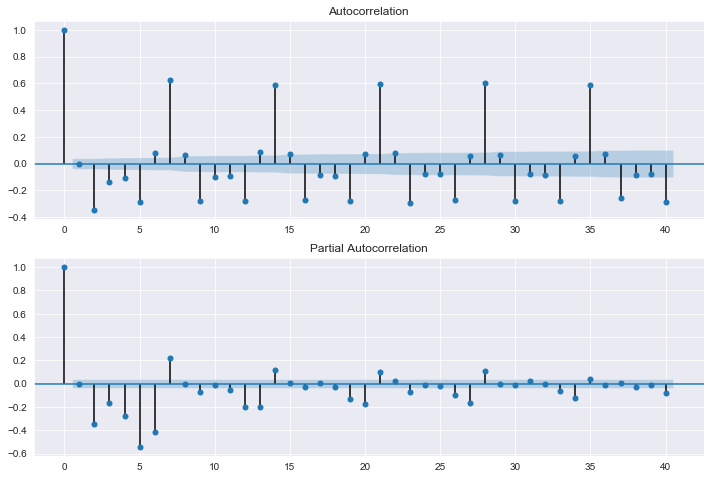

In [49]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

* Aqui podemos ver que o acf e o pacf tem um padrão recorrente a cada 7 períodos. Indicando que existe um padrão semanal.

* Sempre que aparece um padrão regular assim em um desses gráficos, devemos suspeitar que existe algum tipo de sazonalidade acontecendo. Então, devemos começar a considerar o SARIMA para levar a sazonalidade em conta 

## Construindo os Modelos

### ARIMA

O primeiro método de previsão é ARIMA( Auto-Regressive Integrated Moving Averages), para isso usamos três coeficientes (p,d,q):

* AR: Auto-Regressivo (p): Os termos de AR são apenas defasagens da variável dependente. Por exemplo, digamos que p seja 3, usaremos x (t-1), x (t-2) e x (t-3) para prever x(t);

* I: Integrado (d): São o número de diferenças não sazonais;

* MA: Médias Móveis (q): Os termos MA são erros de previsão defasados na equação de previsão.

Para escolher os parâmetros p, d, q, usaremos os gráficos ACF e PACF:

* Escolhendo p: O valor de atraso (lag) onde o gráfico PACF cruza o intervalo de confiança superior pela primeira vez. p = 7.

* Escolhendo d: É fácil determinar, em nosso caso, como os dados já ficaram estacionários antes da primeira diferenciação, temos d=0; 

* Escolhendo q: O valor de atraso (lag) em que o gráfico ACF cruza o intervalo de confiança superior pela primeira vez. Deveria ser q = 7, mas , experimentalmente, essa valor não converge, usamos q=1 que é onde o lag cruza o intervalo de confiança na parte inferior pela primeira vez. 

Para ver o desempenho do nosso primeiro modelo, podemos representar graficamente a distribuição residual e os gráficos de ACF e PACF. Para um bom modelo, queremos ver se o resíduo é uma distribuição normal, além dos gráficos de ACF e PACF não terem termos significativos fora do intervalo e confiança. 


Teste de Normalidade:
NormaltestResult(statistic=199.3751628025837, pvalue=5.08432710043495e-44)


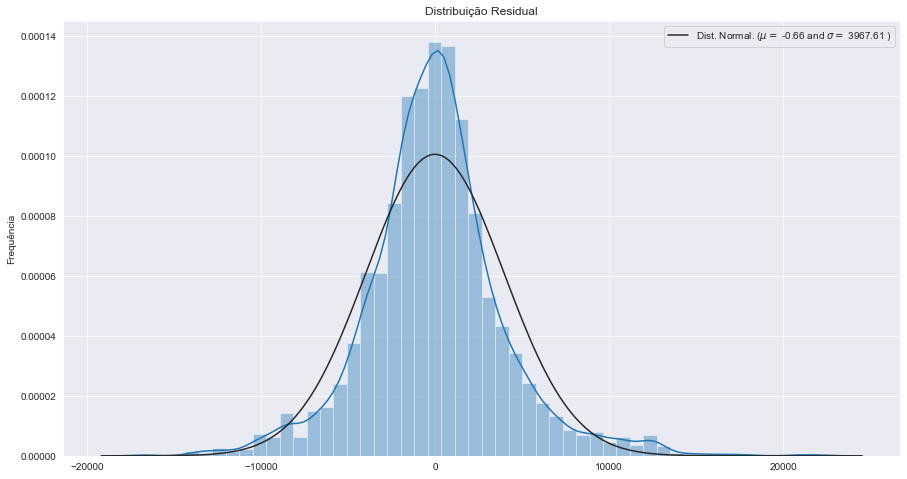

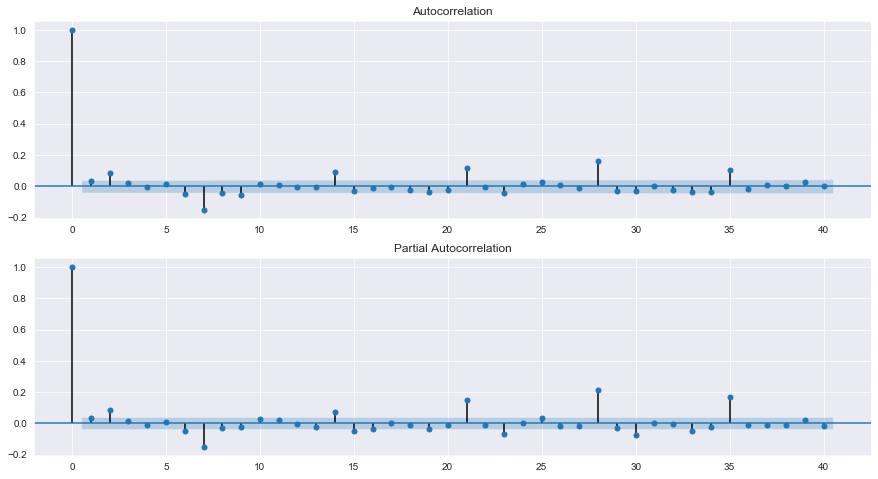

In [50]:
# modelo ARIMA
arima_mod = ARIMA(train_df.passflow, (7,0,1)).fit(disp=False)

# Calcula o resíduo
resid = arima_mod.resid
print("Teste de Normalidade:")
print(normaltest(resid))

# gráfico dos resíduos e de uma distribuição normal pra comparação
fig = plt.figure(figsize=(15,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid, fit = stats.norm, ax = ax0)

(mu, sigma) = stats.norm.fit(resid)

plt.legend(['Dist. Normal. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequência')
plt.title('Distribuição Residual')

# ACF and PACF do modelo ARIMA
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod.resid, lags=40, ax=ax2)

* O Teste de normalidade devolve dois valores, o Chi-quadrado e o p-valor associado. Se o valor p é muito pequeno, significa que o residual é uma distribuição normal.

* Também vemos que existe uma correlação recorrente tanto no ACF quanto no PACF. Portanto, precisamos lidar com a sazonalidade.

### Considere a sazonalidade afetada por SARIMA

A grande diferença entre um modelo ARIMA e um modelo SARIMA é a adição de componentes de erro sazonal ao modelo. O objetivo de um modelo ARIMA é fazer com que as séries temporais com as quais se está trabalhando funcionem como uma série estacionária. Isso é importante porque, se não for estacionário, você pode obter estimativas tendenciosas dos coeficientes. Não há diferença com um modelo SARIMA. Ainda estamos tentando fazer com que a série se comporte de forma estacionária.

Teste de Normalidade
NormaltestResult(statistic=199.3751628025837, pvalue=5.08432710043495e-44)


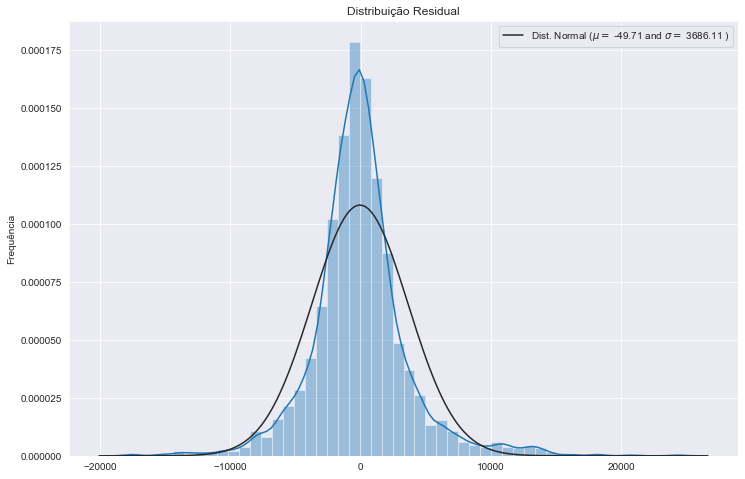

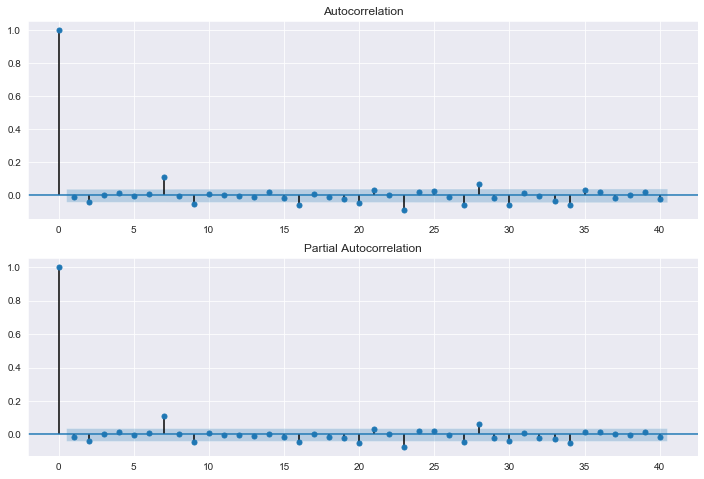

In [51]:
sarima_mod = SARIMAX(train_df.passflow, trends='n', order=(8,2,8)).fit()

resid_sarima = sarima_mod.resid
print("Teste de Normalidade")
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid_sarima, fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid_sarima)

#Now plot the distribution using 
plt.legend(['Dist. Normal ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequência')
plt.title('Distribuição Residual')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarima_mod.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarima_mod.resid, lags=40, ax=ax2)

* Temos uma distribuição normal dos resíduos

* Conseguimos eliminar os efeitos de sazonalidade nos gráficos de ACF e PACF

## Previsões e Avaliações

Aqui vamos testar os modelos realizando previsões e avaliando as métricas. Vamos selecionar os últimos 50 dados para fazer uma previsão.

In [52]:
# função que calcula o erro absoluto médio e o erro absoluto médio simétrico
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

MAPE: 9.47 % 
SMAPE: 9.33 %


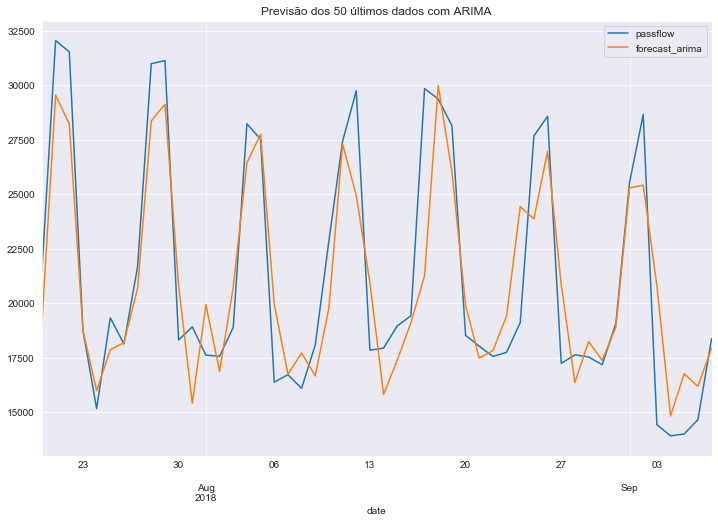

In [53]:
# previsão com o ARIMA
train_df['forecast_arima'] = arima_mod.predict()  
train_df[-50:][['passflow', 'forecast_arima']].plot(figsize=(12, 8))
plt.title("Previsão dos 50 últimos dados com ARIMA")

smape_kun(train_df[-50:]['passflow'],train_df[-50:]['forecast_arima'])


Para o modelo ARIMA:

* As previsões estão coerentes com os dados

* Temos um erro de 9.4% nas previsões.

MAPE: 8.59 % 
SMAPE: 8.47 %


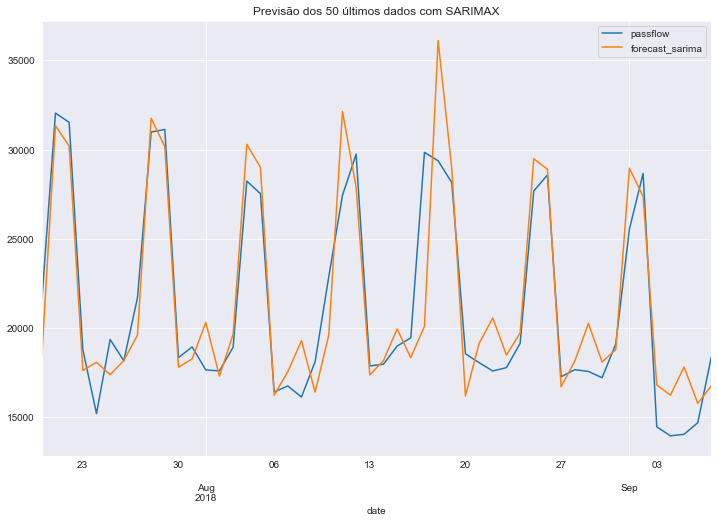

In [54]:
# previsão com SARIMAX
train_df['forecast_sarima'] = sarima_mod.predict()  
train_df[-50:][['passflow', 'forecast_sarima']].plot(figsize=(12, 8))
plt.title("Previsão dos 50 últimos dados com SARIMAX")

smape_kun(train_df[-50:]['passflow'],train_df[-50:]['forecast_sarima'])

Para o modelo SARIMAX:

* As previsões são mais próximas dos dados

* Temos um erro de 8.5%.

## Conclusão

Conseguimos criar um modelo estatístico usando SARIMA que prevê o fluxo de clientes com um erro de previsão de 8.5%. Por exemplo, suponhamos que queiramos saber quantos clientes entraram no estabelecimento na data de '2019-02-08':

In [55]:
print('Fluxo de Clientes:')
sarima_mod.predict('2019-02-08')


Fluxo de Clientes:


2019-02-08    11362.916701
Freq: D, dtype: float64